In [2]:
import torch
from CNN.models import MlpRegBaseline
from CNN.datasets import Class_Seq_Dataset
from CNN.datasets import load_class_seq_data
import matplotlib.pylab as plt
import sys

/home/daqop/anaconda3/envs/deeprank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# useful functions:
def renorm(data, mean, std):
    data = torch.logit(data)
    data = data*std+mean
    return torch.log(data)


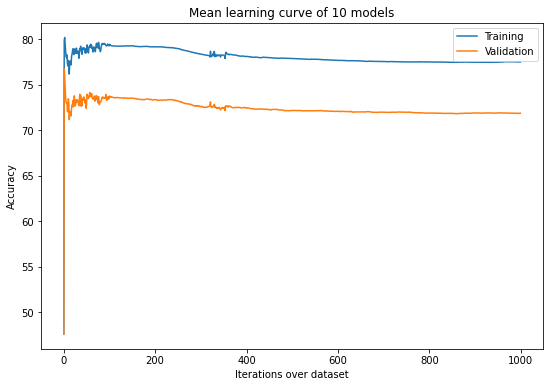

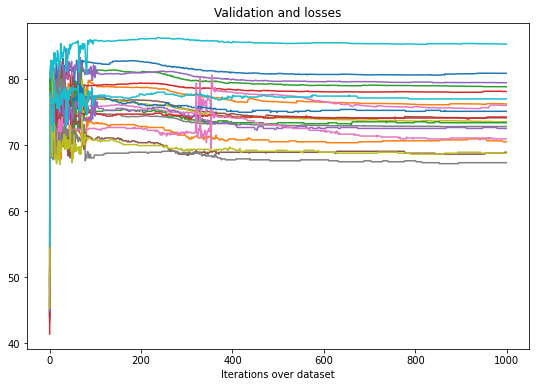

In [3]:
# models_path = "/home/daqop/Desktop/M2/Internship/python/trained_models/"
# models_path = "/home/daqop/mountpoint_snellius/3D-Vac/src/5_train_models/CNN/I/reg/seq/trained_models/"
models_path = "/home/daqop/train_branch_3D_Vac/src/5_train_models/CNN/I/classification/seq/trained_models/"
model_name = "mlp_class_baseline_500_neurons_1000_epochs_sig_norm.pt"
models_path = models_path + model_name
cp = torch.load(models_path)
xval_data = cp["models_data"]
a = cp["arguments"]

train_losses = torch.tensor([data["train_losses"] for data in xval_data])
validation_losses = torch.tensor([data["validation_losses"] for data in xval_data])
train_losses = torch.permute(train_losses, (1,0))
validation_losses = torch.permute(validation_losses, (1,0))

#plot mean validation and loss
plt.figure(figsize=(9,6))
plt.plot(range(a.epochs), train_losses.mean(dim=1))
plt.plot(range(a.epochs), validation_losses.mean(dim=1))
plt.title("Valid")
plt.xlabel("Iterations over dataset")
plt.ylabel("Accuracy")
plt.title("Mean learning curve of 10 models")
plt.legend(["Training", "Validation"])
plt.show()

#plot the actual validation and loss
plt.figure(figsize=(9,6))
plt.plot(range(a.epochs), train_losses)
plt.plot(range(a.epochs), validation_losses)
plt.title("Validation and losses")
plt.xlabel("Iterations over dataset")
plt.show()

In [4]:

# plot the r-squared and other metrics for each model
all_indices = []
csv_peptides, csv_ba_values = load_class_seq_data("../../data/external/processed/BA_pMHCI.csv", a.threshold)
dataset = Class_Seq_Dataset(csv_peptides, csv_ba_values, a.encoder)
accuracies = []
tpr = []
fpr = []
tnr = []
fnr = []
for data in xval_data:
    # load the model and data
    model = MlpRegBaseline(neurons_per_layer=a.neurons) 
    model.load_state_dict(data["model"])
    model.eval()

    test_X = dataset.peptides[data["test_indices"]]
    test_label = dataset.labels[data["test_indices"]]

    with torch.no_grad():
        # make the prediction on the test dataset
        # calculate raw accuracy:
        test_pred_label = torch.reshape(model(test_X), (-1,))
        accuracy = float((test_pred_label.round() == test_label).sum()/test_label.shape[0])
        accuracies.append(accuracy)

        # calculate rates for the ROC and AUC:
        confusion = test_pred_label.round()/test_label
        tot = test_label.shape[0]

        tpr.append( float((confusion == 1.).sum()/tot) )
        fpr.append( float((confusion == float("inf")).sum()/tot) )
        tnr.append( float(torch.isnan(confusion).sum()/tot) ) 
        fnr.append( float((confusion == 0.).sum()/tot))
print(f"mean accuracy: {torch.tensor(accuracies).mean()}")
print(f" mean true positive rate: {torch.tensor(tpr).mean()}")
print(f" mean false positive rate: {torch.tensor(fpr).mean()}")
print(f" mean true negative rate: {torch.tensor(tnr).mean()}")
print(f" mean false negative rate: {torch.tensor(fnr).mean()}")
print(tpr,fpr,tnr,fnr)


mean accuracy: 0.7309201955795288
 mean true positive rate: 0.28736671805381775
 mean false positive rate: 0.11469493806362152
 mean true negative rate: 0.44355350732803345
 mean false negative rate: 0.15438488125801086
[0.1306597739458084, 0.24320827424526215, 0.381630003452301, 0.240620955824852, 0.2173350602388382, 0.3156532943248749, 0.2318652868270874, 0.23704662919044495, 0.35362693667411804, 0.522020697593689] [0.07632600516080856, 0.1086675301194191, 0.12419146299362183, 0.09443725645542145, 0.06468304991722107, 0.08667529374361038, 0.1334196925163269, 0.053108807653188705, 0.15025906264781952, 0.25518134236335754] [0.4644243121147156, 0.5472186207771301, 0.3596377670764923, 0.5032341480255127, 0.43208280205726624, 0.46054333448410034, 0.5479274392127991, 0.4831606149673462, 0.4455958604812622, 0.19170984625816345] [0.32858991622924805, 0.10090555995702744, 0.13454075157642365, 0.16170763969421387, 0.2858991026878357, 0.1371280699968338, 0.08678756654262543, 0.22668394446372986